# CREATE CRITICAL PAIRS DICT

In [ ]:
import json
import matplotlib.pyplot as plt
import networkx as nx

# Carica i dati
def load_json(filepath):
    with open(filepath, 'r') as f:
        return json.load(f)

gs_dict = load_json('ENTHALPY/EntGS.json')

# Inizializza la struttura dati per il grafo
compositions = []
pair_data = {}
filtered_pairs = {}

for comp in gs_dict.keys():
    
    if comp in ['6']:  # Escludi la composizione 6
        continue
    
    filtered_pairs[comp] = {}
    pair_count_dict = {}
    data_ent = load_json(f'ENTHALPY/A{comp}B.json')
    
    for pair in data_ent.keys():
        pair_count_dict[pair] = sum(1 for temp in data_ent[pair] if data_ent[pair][temp] - gs_dict[comp][pair] < 0.1)
    
    filtered_pairs[comp] = {pair: count for pair, count in pair_count_dict.items() if count < 1}

with open('CriticalPairs.json', 'w') as f:
    json.dump(filtered_pairs, f, indent=4)

# HULLS

In [ ]:
import json
import re

with open('CriticalPairs.json', 'r') as f:
    data = json.load(f)

pairs_to_check = []
for comp in data.keys():
    pairs_to_check.extend(list(data[comp].keys()))

pairs_to_check = list(set(pairs_to_check))

to_remove = []
for i in pairs_to_check:
    if i in to_remove:
        continue
    A = re.search(r'([A-Z][a-z]*)([A-Z][a-z]*)', i).group(1)
    B = re.search(r'([A-Z][a-z]*)([A-Z][a-z]*)', i).group(2)
    listab = [A,B]
    listab.sort()
    if A == listab[0]:
        continue
    else:
        pairs_to_check.append(f'{B}{A}')
        to_remove.append(i)


pairs_to_check = [i for i in pairs_to_check if i not in to_remove]

In [ ]:
import matplotlib.pyplot as plt
import re
from scipy.spatial import ConvexHull
import numpy as np 
import json

x = [0,1/5,1/4,1/3,1/2,2/3,3/4,4/5,1]
#x = [0,1/7,1/5,1/4,1/3,1/2,2/3,3/4,4/5,6/7,1]

with open('ConvexHulls_GS.json', 'w') as f:
    gs_hulls = json.load(f)

with open('ConvexHulls.json', 'w') as f:
    temp_hulls = json.load(f)


for pair in pairs_to_check:
    fig, ax = plt.subplots(1,1, figsize=(18,10))
    ax.set_title(f'{pair}', fontsize=22, fontweight='bold')
    A = re.search(r'([A-Z][a-z]*)([A-Z][a-z]*)', pair).group(1)
    B = re.search(r'([A-Z][a-z]*)([A-Z][a-z]*)', pair).group(2)

    y_uspex = [j for j in gs_hulls[pair]]
    y_uspex.insert(0,0)
    y_uspex.append(0)
    y_temp = [j for j in temp_hulls[pair]]
    y_temp.insert(0,0)
    y_temp.append(0)

    points_temp = np.column_stack((x, y_temp))
    points_uspex = np.column_stack((x, y_uspex))

# Calcoliamo la convex hull
    hull_temp = ConvexHull(points_temp)
    hull_uspex = ConvexHull(points_uspex)

    hull_edges_us = []
    for simplex in hull_uspex.simplices:
        x1, y1 = points_uspex[simplex[0]]
        x2, y2 = points_uspex[simplex[1]]
        if y1 == 0 and y2 == 0:  # Consideriamo solo segmenti interamente sotto y = 0
            continue
        if y1 <= 0 and y2 <= 0:  # Consideriamo solo segmenti interamente sotto y = 0
            hull_edges_us.append((x1, y1, x2, y2))
    if len(hull_edges_us) == 0:
        hull_edges_us.append((0,0,1,0))
        
    
    hull_edges_temp = []
    for simplex in hull_temp.simplices:
        x1, y1 = points_temp[simplex[0]]
        x2, y2 = points_temp[simplex[1]]
        if y1 == 0 and y2 == 0:
            continue
        if y1 <= 0 and y2 <= 0:  # Consideriamo solo segmenti interamente sotto y = 0
            hull_edges_temp.append((x1, y1, x2, y2))
    if len(hull_edges_temp) == 0:
        hull_edges_temp.append((0,0,1,0))

    ax.scatter(x, y_temp, label = 'Template', color = 'red' , marker = 'o', edgecolors='black', s=100)
    ax.scatter(x, y_uspex, label = 'USPEX', color = 'black', marker = 'o', edgecolors = 'black', s=60)
    for x1, y1, x2, y2 in hull_edges_us:
        ax.plot([x1, x2], [y1, y2], 'k--', lw=4)
    for x1, y1, x2, y2 in hull_edges_temp:
        ax.plot([x1, x2], [y1, y2], 'r--', lw=2)


    ax.set_xticks(x)
    #ax.set_xticklabels([A, f'{A}$_6${B}', f'{A}$_4${B}', f'{A}$_3${B}', f'{A}$_2${B}', f'{A}{B}', f'{A}{B}$_2$', f'{A}{B}$_3$', f'{A}{B}$_4$', f'{A}{B}$_6$', B], fontsize=15, family='serif')
    ax.set_xticklabels([A, f'{A}$_4${B}', f'{A}$_3${B}', f'{A}$_2${B}', f'{A}{B}', f'{A}{B}$_2$', f'{A}{B}$_3$', f'{A}{B}$_4$',  B], fontsize=15, family='serif')


    ax.set_xlabel('Composition', fontsize=20, family='serif')
    ax.set_ylabel('Formation Energy (eV/atom)', fontsize=20, family='serif')
    ax.grid(True, linestyle='--')
    ax.legend(loc= 'upper center', fontsize=15)

# USPEX STRUCTURES

In [2]:
import json
import os
from template_csp.manageuspex import read_individuals, delete_duplicates
from tqdm import tqdm


with open('DATA_DICT/CriticalPairs.json', 'r') as f:
    data = json.load(f)

complist = [1,2,3,4,6]

for comp in complist:
    os.makedirs(f'CRITICAL_PAIRS/{comp}/', exist_ok=True)
    for i in tqdm(os.listdir(f'TEMPLATES/SETUP_COMP{comp}/all_Individuals/')):
        pair = i.split('_')[0]
        df = read_individuals(f'TEMPLATES/SETUP_COMP{comp}/all_Individuals/{pair}_Individuals')
        df = delete_duplicates(df, f'TEMPLATES/SETUP_COMP{comp}/all_poscars/{pair}_gatheredPOSCARS', 0.2)
        df.to_csv(f'CRITICAL_PAIRS/{comp}/{pair}_Individuals.csv', index=False)


100%|██████████| 210/210 [02:12<00:00,  1.58it/s]


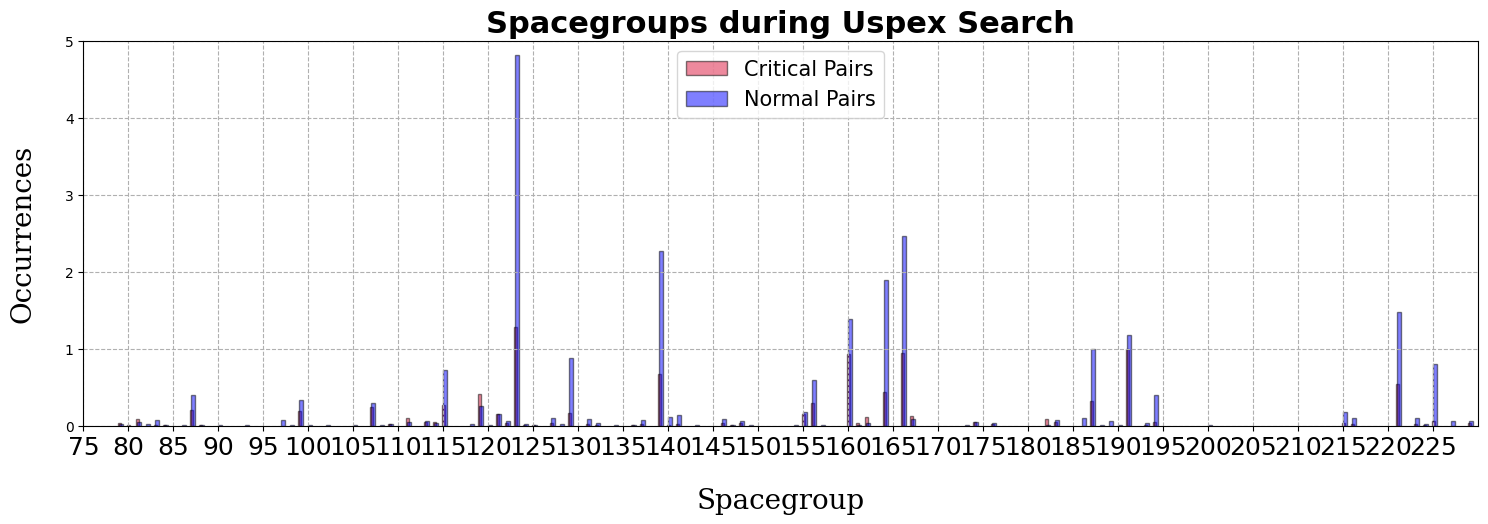

In [1]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt

with open('DATA_DICT/CriticalPairs.json', 'r') as f:
    data = json.load(f)
occurrences_crit = {}

for comp in data.keys():
    for pair in data[comp].keys():
        df = pd.read_csv(f'CRITICAL_PAIRS/{comp}/{pair}_Individuals.csv')
        list_for_hist = df['spacegroup'].tolist()
        list_for_hist = [int(i) for i in list_for_hist]
        for sg in list_for_hist:
            if sg in occurrences_crit.keys():
                occurrences_crit[sg] += 1/114
            else:
                occurrences_crit[sg] = 1/114
    
occurrences_normal = {}
for comp in os.listdir('CRITICAL_PAIRS/'):
    if comp == '6':
        continue
    for pair_individuals in os.listdir(f'CRITICAL_PAIRS/{comp}/'):
        pair = pair_individuals.split('_')[0]
        if pair in data[comp].keys():
            continue
        df = pd.read_csv(f'CRITICAL_PAIRS/{comp}/{pair}_Individuals.csv')
        list_for_hist = df['spacegroup'].tolist()
        list_for_hist = [int(i) for i in list_for_hist]
        for sg in list_for_hist:
            if sg in occurrences_normal.keys():
                occurrences_normal[sg] += 1/621
            else:
                occurrences_normal[sg] = 1/621



fig, ax = plt.subplots(1,1, figsize=(18,5))
ax.set_title(f'Spacegroups during Uspex Search', fontsize=22, fontweight='bold')
ax.bar(occurrences_crit.keys(), occurrences_crit.values(), color='crimson', label='Critical Pairs', alpha=0.5, width=0.4, align='center', edgecolor='black')
ax.bar(occurrences_normal.keys(), occurrences_normal.values(), color='blue', label='Normal Pairs', alpha=0.5, width=0.4, align='edge', edgecolor='black')
ax.set_xticks([i for i in range(75, 230, 5)])
ax.set_xticklabels([i for i in range(75, 230, 5)], fontsize=18)
# ax.set_yticks([i for i in range(0, 70, 10)])
# ax.set_yticklabels([i for i in range(0, 70, 10)], fontsize=18)
ax.set_xlabel('Spacegroup', fontsize=20, family='serif', labelpad=20)
ax.set_ylabel('Occurrences', fontsize=20, family='serif', labelpad=20)
ax.grid(True, linestyle='--')
ax.legend(loc= 'upper center', fontsize=15)
ax.set_ylim(0,5)
ax.set_xlim(75, 230)

plt.show()




In [ ]:
import json
with open('DATA_DICT/CriticalPairs.json', 'r') as f:
    data = json.load(f)
summa = 0
for comp in data.keys():
    summa += len(data[comp].keys())
print(summa)